# Association rule/pattern mining for recommender system

## Outline

* Task description
* Import libriaries and load data
* Analyse and Pre-process Data
* Use Surprise to train and tune collaborative filtering model 
* Evaluate the model and recommendation preformance
* Build a scaled up system
* Generate recommendations

## Task <a class="anchor" id="task"></a>

1 person: Recommendation system
Download the data, write the code in Python to generate recommendations using collaborative filtering method from the training dataset. Your method should be able to generate recommendations from big data and for large number of users and be scalable. Your method should score recommendations for a user to select top recommendations. Select a metric to measure the performance. Write code to test the recommendations on the test set.

## Import libriaries and load data <a id="loading"></a>

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

# Similarity
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict

# supress warnings
import warnings
warnings.filterwarnings("ignore")

Load Data

In [2]:
# load trainng and test data 
data_train = pd.read_csv('basket_data_by_date_train.csv')

data_test = pd.read_csv('basket_data_by_date_test.csv')

data_train.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [3]:
data_test.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


## Analyse and Pre-process Data <a class="anchor" id="Pre-process"></a>

check the missing value for training and test data

In [4]:
print('Shape of data:', data_train.shape)

Shape of data: (40000, 7)


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


In [3]:
data_train.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

There is no missing value for training set

In [3]:
data_test.shape

(40000, 7)

In [4]:
data_test.isnull().sum()

BillNo        30000
Itemname      30000
Quantity      30000
Date          30000
Price         30000
CustomerID    30000
cost          30000
dtype: int64

In [5]:
# delete the null value in test set
data_test = data_test[~data_test["BillNo"].isnull()]

In [6]:
data_test.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

There is no null values in test set after data cleaning

Removes blank spaces 

In [6]:
data_train['Itemname'] = data_train['Itemname'].str.strip()
data_test['Itemname'] = data_test['Itemname'].str.strip()

Change the type of 'CustomerID', 'BillNo' to str, 'Quantity' to int for test data

In [7]:
data_test['CustomerID'] = data_test['CustomerID'].astype(int).astype(str)
data_test['BillNo'] = data_test['BillNo'].astype(int).astype(str)
data_test['Quantity'] = data_test['Quantity'].astype(int)

In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      10000 non-null  object 
 1   Itemname    10000 non-null  object 
 2   Quantity    10000 non-null  int64  
 3   Date        10000 non-null  object 
 4   Price       10000 non-null  float64
 5   CustomerID  10000 non-null  object 
 6   cost        10000 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 625.0+ KB


Change the type of 'CustomerID', 'BillNo' to str for training data

In [9]:
data_train['CustomerID'] = data_train['CustomerID'].astype(str)
data_train['BillNo'] = data_train['BillNo'].astype(str)

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  object 
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  object 
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.1+ MB


check the vlidity of the data, make sure it is meaningful

In [10]:
data_train[(data_train['Quantity']<=0) | (data_train['Price']<=0) | (data_train['cost']<=0) ].head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


In [11]:
data_test[(data_test['Quantity']<=0) | (data_test['Price']<=0) | (data_test['cost']<=0) ].head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


All values of Quantity, Price and cost of transaction data are meaningful.

In [10]:
data_train["Date"] = pd.to_datetime(data_train["Date"], format="%d/%m/%Y %H:%M")

In [11]:
data_train.describe()

,Quantity,Date,Price,cost
count,40000.000000,40000,40000.000000,40000.000000
mean,3.487700,2011-01-04 13:22:57.648000,3.732165,11.097411
min,1.000000,2010-12-01 08:26:00,0.100000,0.140000
25%,1.000000,2010-12-09 14:49:00,1.650000,3.300000
50%,2.000000,2011-01-06 17:10:00,2.950000,7.950000
75%,6.000000,2011-01-27 12:40:00,4.650000,15.800000
max,10.000000,2011-02-18 12:27:00,295.000000,527.700000
std,2.611766,NaN,5.711630,13.298301


After data cleaning, there are 40000 observations in training set and 10000 observations in test set. Dates range from December 1，2010 to February 18，2011.

Show the unique number of customers and items

In [14]:
data_train["CustomerID"].nunique(), data_train["Itemname"].nunique()

(1391, 2523)

In the training set, 1391 different customers have purchased 2523 different items.

Use word clouds to show the frequency of items in the training dataset

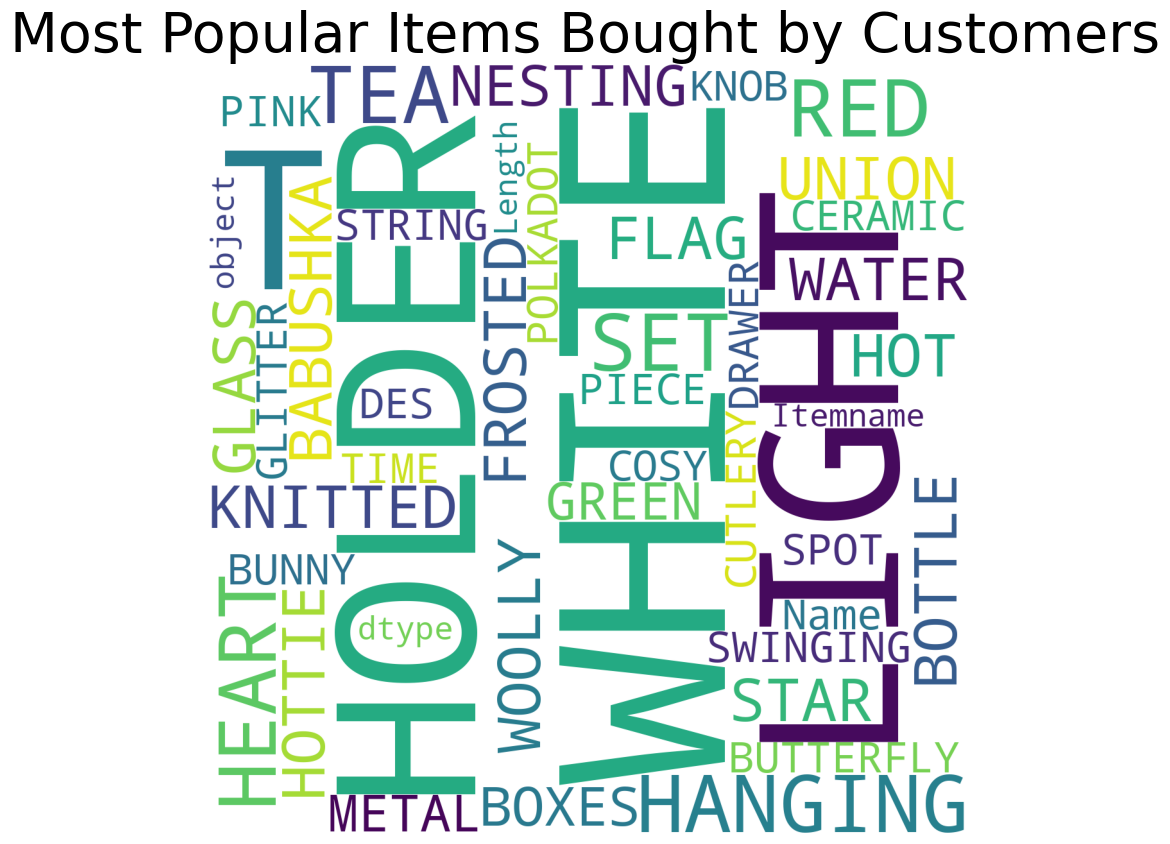

In [35]:
plt.rcParams['figure.figsize'] = (15, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, min_font_size = 3).generate(str(data_train['Itemname']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items Bought by Customers',fontsize = 40)
plt.show()

In [14]:
item_count = data_train.groupby(["Itemname"])["Quantity"].sum().reset_index().sort_values("Quantity", ascending = False)

item_count.reset_index(level = 0, inplace=True)


item_count.head(10)

,index,Itemname,Quantity
0,2436,WHITE HANGING HEART T-LIGHT HOLDER,1262
1,1183,JUMBO BAG RED RETROSPOT,1008
2,1289,LUNCH BAG RED RETROSPOT,1007
3,153,ASSORTED COLOUR BIRD ORNAMENT,840
4,1092,HEART OF WICKER LARGE,726
5,1998,SET OF 3 CAKE TINS PANTRY DESIGN,712
6,1422,NATURAL SLATE HEART CHALKBOARD,706
7,1189,JUMBO SHOPPER VINTAGE RED PAISLEY,667
8,1795,RED HANGING HEART T-LIGHT HOLDER,666
9,1291,LUNCH BAG SUKI DESIGN,661


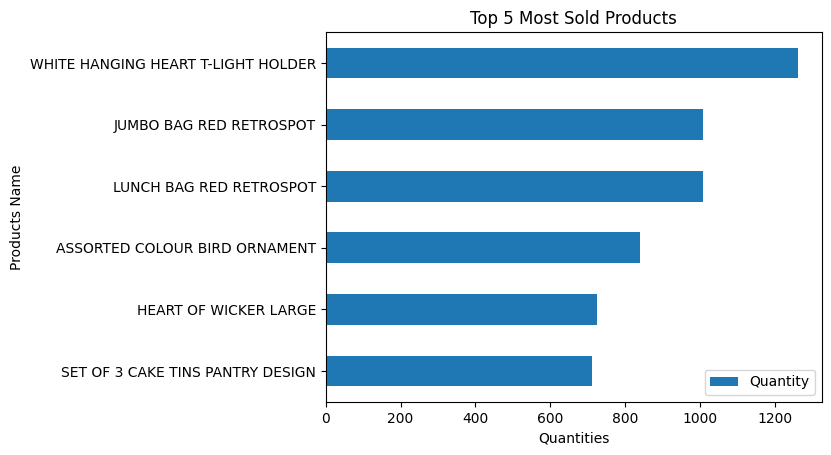

In [15]:
item_count_top5 = item_count.loc[0:5,["Itemname", "Quantity"]].sort_values("Quantity", ascending = True)


item_count_top5.plot(kind = "barh", x = "Itemname", align = "center")
plt.ylabel('Products Name')
plt.xlabel('Quantities')
plt.title('Top 5 Most Sold Products')
plt.show()

From above word cloud and bar chart, we can see the top five most frequently selling items are:
* WHITE HANGING HEART T-LIGHT HOLDER	
* JUMBO BAG RED RETROSPOT
* LUNCH BAG RED RETROSPOT	
* ASSORTED COLOUR BIRD ORNAMENT
* HEART OF WICKER LARGE

We might expect these top selling items to be mostly recommended in our recommender.

In [88]:
data_temp = data_train.copy()
data_temp["Hour"] = data_temp["Date"].dt.hour
data_temp["Day"] = data_temp["Date"].dt.date
data_temp['Month'] = data_temp['Date'].dt.strftime('%b')
data_temp.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost,Hour,Day,Month
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,20.34,8,2010-12-01,Dec
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,25.50,8,2010-12-01,Dec
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,15.30,8,2010-12-01,Dec
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,20.34,8,2010-12-01,Dec
4,536365,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,15.30,8,2010-12-01,Dec


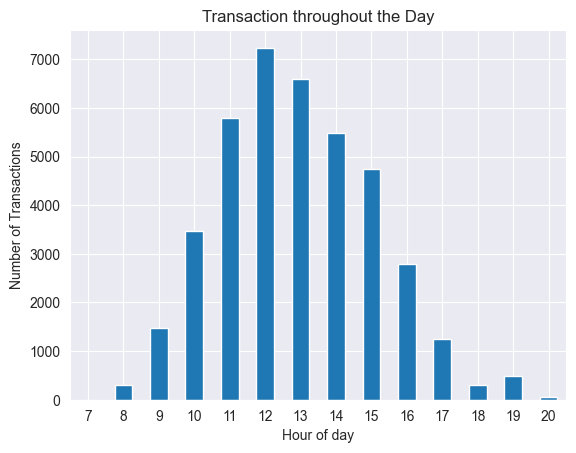

In [82]:
salesbyhour = data_temp.groupby(["Hour"])["BillNo"].count()

salesbyhour.plot(kind = "bar", x = "BillNo")
plt.xlabel("Hour of day")
plt.ylabel("Number of Transactions")
plt.title("Transaction throughout the Day")
plt.xticks(rotation=0)
plt.show()

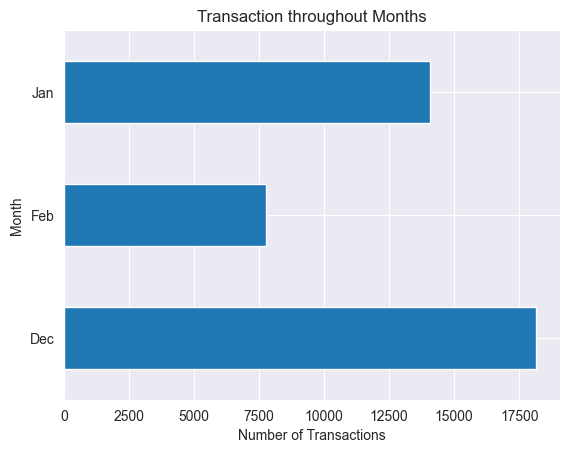

In [86]:
salesbymonth = data_temp.groupby(['Month'])['BillNo'].count()
salesbymonth.plot(kind = "barh")
plt.xlabel("Number of Transactions")
plt.ylabel("Month")
plt.title("Transaction throughout Months")
plt.show()

From the chart above, we can see that the shop trades most frequently in the middle of the day and in the afternoon, and that of all the months for which data is given, December has the highest number of trades. The data shows a trend that matches reality well, with transactions mostly done during the day, and with Christmas in December, transactions tend to be higher as well.

As this project focuses on exploring the relationship between users and items in customer transactions. In order to more easily form a recommendation system and to better focus on user-item research, when studying a user's spending history we will only consider the items purchased themselves as well as the number of items purchased, and will not study the date of purchase. Date-based research is used to give merchants a more intuitive understanding of their customers' preferred shopping times and months, which makes it easier for merchants to prepare their products.

In [147]:
items_count = pd.DataFrame((data_temp.groupby(['BillNo'])['BillNo'].count())).reset_index(drop=True)
items_count.head()

,BillNo
0,7
1,2
2,11
3,4
4,1


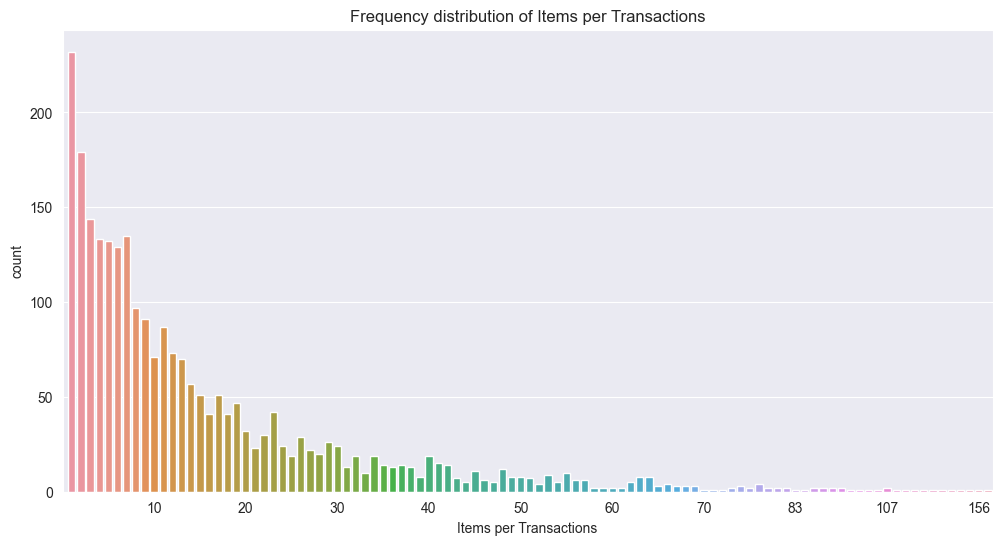

In [148]:
plt.figure(figsize=(12, 6))
sns.countplot(x='BillNo', data=items_count)
plt.xlabel('Items per Transactions')
plt.title('Frequency distribution of Items per Transactions')

plt.xticks(np.arange(-1, 100, 10))
plt.show()

In [149]:
items_count.describe()

,BillNo
count,2524.000000
mean,15.847861
std,18.620706
min,1.000000
25%,4.000000
50%,9.000000
75%,20.250000
max,244.000000


We can see that the number of items purchased per transaction is very wide ranging from 1 to 244 respectively. From the distribution graph and the data, we get the top quartile as 4 and the median as 9. We choose 9 as the recommended number of items.

Show the long tail

In [33]:
def plot_long_tail(item_names_column):
    # Count the frequency of each item
    item_count = item_names_column.value_counts()

    # Set threshold to 50% of total items bought by item rankings
    threshold = 0.5
    cumulative_freq_products = np.cumsum(item_count)
    popularity_threshold_item = len(cumulative_freq_products[cumulative_freq_products < item_count.sum() * threshold])
    popularity_threshold = item_count[popularity_threshold_item+1]

    fig, ax = plt.subplots(figsize=(10,5), dpi=100)

    # Plotting the count of each unique item by separating them with reference to popularity threshold
    for i in range(len(item_count)):
        if item_count[i] >= popularity_threshold:
            ax.bar(i, item_count[i], color="red")
        else:
            ax.bar(i, item_count[i], color="orange")

    # Setting labels and title
    ax.set_xlabel('Ranking of items by frequency of purchase')
    ax.set_ylabel('Frequency of purchase')
    ax.set_title(f'{(1-threshold)*100}% of items were bought less than {popularity_threshold} times shown in long-tail')

    # Adding a vertical line to separate popular and unpopular items
    n_popular_items = sum(item_count >= popularity_threshold)
    ax.axvline(x=n_popular_items, color="black")
    
    plt.show()


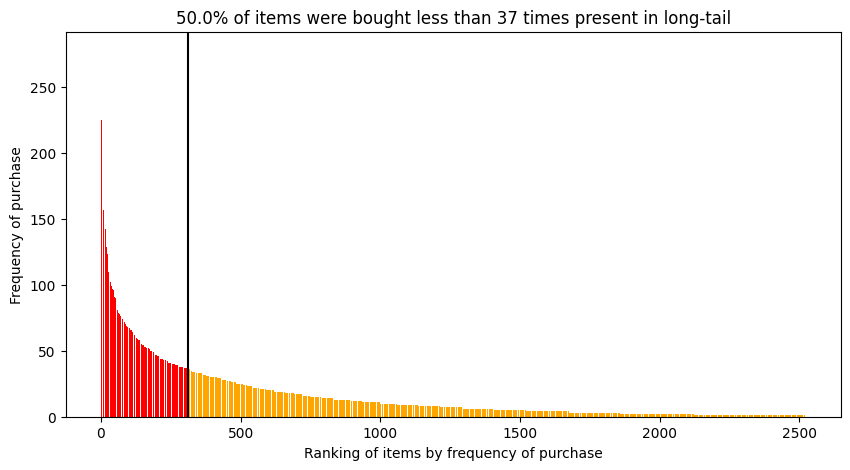

In [34]:
plot_long_tail(data_train["Itemname"])

From the chart above we see that half of the buyers purchased more than 2000 less popular items and a large number of items with low frequencies extending out into a long tail on the graph, indicating the existence of a strong long-tail problem.

In [12]:
data_summary = pd.merge( pd.DataFrame(data_train.CustomerID.value_counts()),
                 pd.DataFrame(data_train.groupby(['CustomerID'])['Itemname'].nunique()),
                 left_index = True, right_index = True).rename(columns = {'Itemname':'unique count', 'CustomerID':'total count'})

pd.DataFrame({"mean unique item count": data_summary['unique count'].mean(),
              "mean total item count": data_summary['count'].mean(),
              "mean Percentage of new items": (data_summary['unique count'].mean()/data_summary['count'].mean())*100,
              "mean Percentage of repeated items": (1-(data_summary['unique count'].mean()/data_summary['count'].mean()))*100},
              index=["For each user's entire transcation"])

,mean unique item count,mean total item count,mean Percentage of new items,mean Percentage of repeated items
For each user's entire transcation,24.654925,28.75629,85.7375,14.2625


From the table above it can be seen that the average percentage of users purchasing new items in each grocery transaction is 85.7, which suggests that they do not purchase the same items over and over again in each transaction. Therefore, it may not be meaningful to study the behavioural patterns of users' grocery transactions by date or transaction number. We can remove the columns where the data represents the date and transaction number and focus on the relationship between users and items.

## Collaborative filtering

Data sets for Recommender Systems often have few items that contain the most ratings, whereas most of the items have very few ratings. This affects accuracy measurements as the accuracy predictions will generally be different on the popular items than the sparsely rated items. A solution to this problem is to give item specific weights toward each of the items when computing RSME or MAE, which are decided by the manager. These could allow for a more accurate representation of how the Recommender System is evaluating all of the items. 

We use Surprise (Hug, N., 2020) library to build the model.

In [13]:
import surprise
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import prediction_algorithms, KNNBasic, SVD

convert training and test set

In [14]:
# to use Reader class, we convert data into: user ; item ; rating 
data_train_convert = data_train[["CustomerID", "Itemname", "Quantity"]]\
    .groupby(by=["CustomerID", "Itemname"])\
    .sum()["Quantity"]\
    .reset_index()

data_test_convert = data_test[["CustomerID", "Itemname", "Quantity"]]\
    .groupby(by=["CustomerID", "Itemname"])\
    .sum()["Quantity"]\
    .reset_index()

In [142]:
data_train_convert.head()

,CustomerID,Itemname,Quantity
0,12347,AIRLINE BAG VINTAGE JET SET BROWN,8
1,12347,AIRLINE BAG VINTAGE JET SET WHITE,4
2,12347,ALARM CLOCK BAKELIKE CHOCOLATE,8
3,12347,ALARM CLOCK BAKELIKE GREEN,8
4,12347,ALARM CLOCK BAKELIKE ORANGE,8


Baseline Model

We use baseline model that predict random ratings for our customers based on the assumed normal distribution of the training set.


In [15]:
def train_baseline_model(trian_set):
    # build baseline
    baseline_model = prediction_algorithms.random_pred.NormalPredictor()

    # load the DataFrame into Surprise Dataset format    
    data_train_surprise = Dataset.load_from_df(trian_set, Reader())

    # train the model
    baseline_model.fit(data_train_surprise.build_full_trainset())

    return baseline_model


In [16]:
baseline_model = train_baseline_model(data_train_convert)

Co-clustering Model

Co-clustering (Wu, Y., 2016) model considers both users and items, generate more accurate recommendations and it usually have better scalability

In [19]:
def train_coclustering_model(trian_set):
    # build co-clustering model
    coclustering_model = prediction_algorithms.co_clustering.CoClustering()

    # load the DataFrame into Surprise Dataset format    
    data_train_surprise = Dataset.load_from_df(trian_set, Reader())

    # train the model
    coclustering_model.fit(data_train_surprise.build_full_trainset())

    return coclustering_model

In [20]:
coclustering_model = train_coclustering_model(data_train_convert)

k-NN Model

K-NN (Anwar, T., 2022) model focus on data itself without any pre assumptions about the underlying data distribution and it can choose item-based or user-based.

In [21]:
def train_knn_model(trian_set, n_neighbors, sim_options):
    
    # build KNNBasic model
    knn_model = KNNBasic(k=n_neighbors,
                         sim_options=sim_options)

    # load the DataFrame into Surprise Dataset format    
    data_train_surprise = Dataset.load_from_df(trian_set, Reader())

    # train the model
    knn_model.fit(data_train_surprise.build_full_trainset())

    return knn_model

tuning the model

In [22]:
# hyperparameter values for KNN
knn_param_grid = {
    'k': [5, 20, 40, 60, 80, 100],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [1, 5]
    }
}

# tuing the model
knn_cv = GridSearchCV(KNNBasic, 
                      knn_param_grid,
                      measures=["rmse", "mae"],
                      cv=5)

# fitting the grid
knn_cv.fit(Dataset.load_from_df(data_train_convert, Reader()))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [23]:
# show best best params for RMSE
knn_cv.best_params["rmse"]

{'k': 20, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}

In [24]:
# use the best params for RMSE to train the model
knn_model = train_knn_model(data_train_convert, knn_cv.best_params["rmse"]['k'], knn_cv.best_params["rmse"]['sim_options'])

Computing the msd similarity matrix...
Done computing similarity matrix.


SVD

Singular Value Decomposition (Ba, Q., 2013) can identify the most important relationships for item-user paris and it is a effective method to deal with sparse data.

In [25]:
def train_svd_model(trian_set, n_factors, n_epochs, lr_all, reg_all):
    
    # build SVD model
    svd_model = SVD(n_factors=n_factors, 
                    n_epochs=n_epochs,
                    lr_all=lr_all,
                    reg_all=reg_all
                    )

    # load the DataFrame into Surprise Dataset format    
    data_train_surprise = Dataset.load_from_df(trian_set, Reader())

    # train the model
    svd_model.fit(data_train_surprise.build_full_trainset())

    return svd_model

tuning the model

In [26]:
# hyperparameter values for SVD
svd_param_grid = {'n_factors': [2, 5, 10, 25, 50], 
                  "n_epochs": [5, 10, 15], 
                  "lr_all": [0.002, 0.005], 
                  "reg_all": [0.4, 0.6]}

# tuing the model
svd_cv = GridSearchCV(SVD, 
                      svd_param_grid,
                      measures=["rmse", "mae"],
                      cv=3)

# fitting the grid
svd_cv.fit(Dataset.load_from_df(data_train_convert, Reader()))

In [27]:
# show best params for RMSE 
svd_cv.best_params["rmse"]

{'n_factors': 50, 'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}

In [28]:
# use the best params for RMSE to train the model
svd_model = train_svd_model(data_train_convert, svd_cv.best_params["rmse"]['n_factors'], svd_cv.best_params["rmse"]['n_epochs'], svd_cv.best_params["rmse"]['lr_all'], svd_cv.best_params["rmse"]['reg_all'])

make predictions

In [33]:
# get distinct item from training set
train_unique_item = list(data_train.Itemname.value_counts().index)

In [34]:
# give top n product recommendations for a user
def recommend_items(model, user_id, item_ids, top_n = 9, current_basket = []):
    
    # store rankings for items
    predicted_ranks = []
    
    # predict rankings for all items
    for item in item_ids:
        predicted_ranks.append(model.predict(uid=user_id, iid=item))
            
    # sort the rankings
    predicted_ranks.sort(key=lambda x: x.est, reverse=True)
    
    # store recommendations
    recommendations = []
    
    # get the top n items from recommendations
    for item in predicted_ranks:
        
        if item.iid not in current_basket:
            recommendations.append((item.iid, item.est))
                        
        # Stop when n recommendations are found
        if len(recommendations) > top_n:
            break
    
    return recommendations[:top_n]


RMSE and MAE

In [35]:
# calculate rmse and mae of the model
def calcualte_metrics(dataset, model):
    
    rmse = 0
    mae = 0
    
    for index, row in dataset.iterrows():
        prediction = model.predict(uid=row["CustomerID"], iid=row["Itemname"]).est
        
        actual = row["Quantity"]
        
        rmse = rmse + (actual - prediction)**2
        mae = mae + abs(actual - prediction)
        
    return {
        'RMSE': (rmse/dataset.shape[0])**0.5,
        'MAE': mae/dataset.shape[0]
    }

Precison and Recall

In [36]:
# generate coverage and precision metrics for recommender systems
def evaluate_recommender(model, data_train, data_test, item_ids, top_n = 9):
    
    # generate baskets for training and test set
    train_baskets = data_train.groupby(by=['CustomerID']).agg(list)
    test_baskets = data_test.groupby(by=['CustomerID']).agg(list)
    
    # initialize counters
    hits = 0
    total_relevant = 0
    total_predictions = 0
    
    # generate recommendations and calculate precison and recall
    for basket in test_baskets.iterrows():
        
        current_basket = []
        
        # get the existing items in the basket
        try:
            current_basket = train_baskets.loc[basket[0]]["Itemname"]
        except:
            pass
        
        # items in test set
        test_basket = basket[1]["Itemname"]
        
        # generate recommendations
        recommendations = recommend_items(model, user_id=basket[0], item_ids = item_ids, top_n=top_n, current_basket=current_basket)   
    
        # extract items of recommendations
        recommendations = [item for item, _ in recommendations]
        
        # calculate total predicted and relevant items
        hits += len(set(test_basket).intersection(set(recommendations)))
        total_relevant += len(set(test_basket))
        total_predictions += top_n
                
    return {
        "Precision": hits/total_predictions,
        "Recall": hits/total_relevant
    }

In [37]:
baseline_metrics = evaluate_recommender(baseline_model, data_train, data_test, train_unique_item)

baseline_metrics

{'Precision': 0.047313209162920145, 'Recall': 0.023344248441956268}

In [38]:
coclustering_metrics = evaluate_recommender(coclustering_model, data_train, data_test, train_unique_item)

coclustering_metrics

{'Precision': 0.0524512952258617, 'Recall': 0.025879370444702652}

In [39]:
knn_metrics = evaluate_recommender(knn_model, data_train, data_test, train_unique_item)

knn_metrics

{'Precision': 0.05159494754870477, 'Recall': 0.02545685011091159}

In [40]:
svd_metrics = evaluate_recommender(svd_model, data_train, data_test, train_unique_item)

svd_metrics

{'Precision': 0.03982016698779704, 'Recall': 0.019647195521284463}

In [43]:
recommender_metrics = pd.DataFrame({"Model":["Baseline","Co-clustering", "KNN", "SVD"], 
                                        "Precision":[baseline_metrics['Precision'],coclustering_metrics['Precision'],knn_metrics['Precision'],svd_metrics['Precision']], 
                                        "Recall": [baseline_metrics['Recall'],coclustering_metrics['Recall'],knn_metrics['Recall'],svd_metrics['Recall']]
                                        }
                                    )

    
recommender_metrics

,Model,Precision,Recall
0,Baseline,0.047313,0.023344
1,Co-clustering,0.052451,0.025879
2,KNN,0.051595,0.025457
3,SVD,0.039820,0.019647


In [80]:
def show_recommender_metrics(recommender_metrics, title):
    df_recommender_metrics = recommender_metrics.melt(id_vars='Model', var_name='Metric', value_name='Value')

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_recommender_metrics, x='Model', y='Value', hue='Metric', palette=['blue', 'green'])
    plt.title(title)
    plt.ylabel('Value')    
    plt.xlabel('Model')
    plt.xticks(rotation=45)

    for p in plt.gca().patches:
        plt.gca().annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

    plt.tight_layout()
    plt.show()

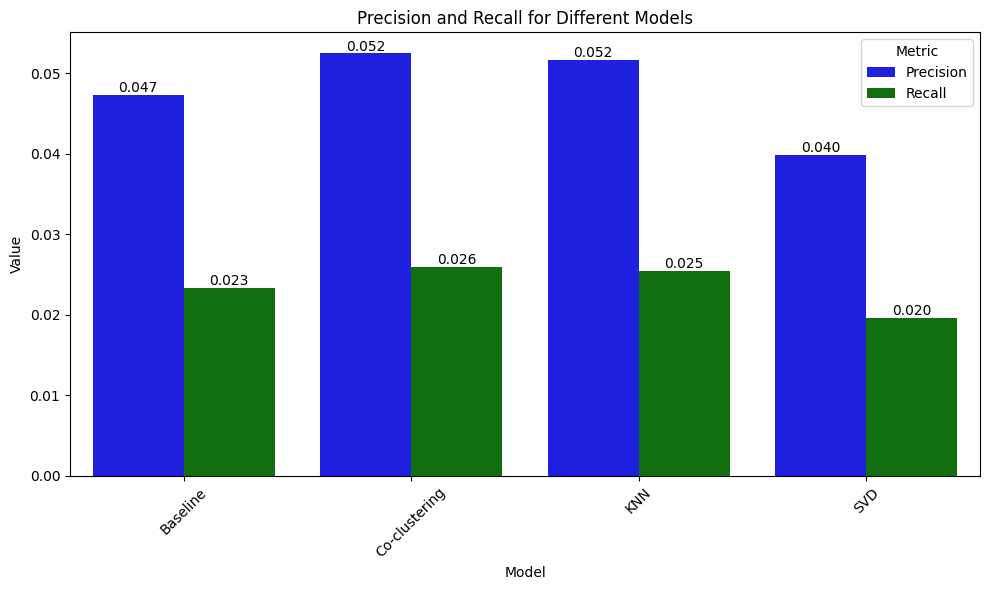

In [81]:
show_recommender_metrics(recommender_metrics, 'Precision and Recall for Different Models')

Evaluating Model with RMSE and MAE

In [46]:

# dataframe to store metrics
models = [  ("Baseline", baseline_model), 
            ("Co-clustering", coclustering_model), 
            ("KNN", knn_model), 
            ("SVD", svd_model)
        ]

performance_metrics = pd.DataFrame({"Model":[], "RMSE":[], "MAE": []})


for name, model in models:
    
    # evaluating the model
    evaluation = calcualte_metrics(data_test_convert, model)

    # adding metrics to dataframe
    performance_metrics = pd.concat([performance_metrics, pd.DataFrame({"Model": [name],
                                             "RMSE": [evaluation["RMSE"]], 
                                             "MAE": [evaluation["MAE"]]})], ignore_index=True)
    
performance_metrics

,Model,RMSE,MAE
0,Baseline,3.258143,2.556187
1,Co-clustering,2.599276,2.050625
2,KNN,2.583654,2.025425
3,SVD,2.436928,1.947459


In [47]:
def show_performance_metrics(performance_metrics, title):
    df_performance_metrics = performance_metrics.melt(id_vars='Model', var_name='Metric', value_name='Value')

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_performance_metrics, x='Model', y='Value', hue='Metric')
    plt.title(title)
    plt.ylabel('Value')    
    plt.xlabel('Model')
    plt.xticks(rotation=45)

    for p in plt.gca().patches:
        plt.gca().annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

    plt.tight_layout()
    plt.show()

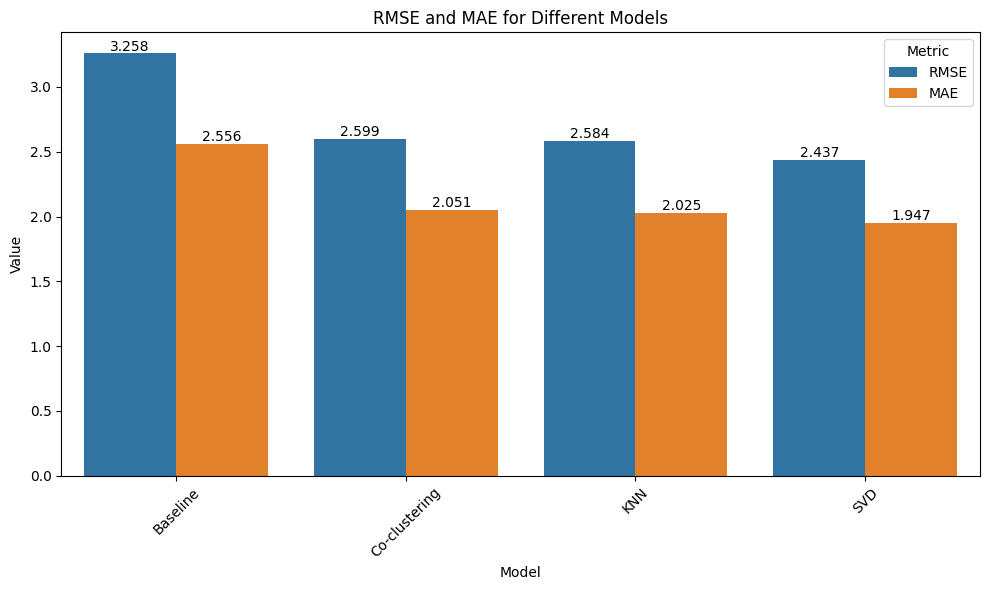

In [48]:
show_performance_metrics(performance_metrics, 'RMSE and MAE for Different Models')

## Build a Scaled-up System

In [49]:
# load bigger trainng and test data 
data_train_big = pd.read_csv('basket_data_by_date_train_big.csv')

data_test_big = pd.read_csv('basket_data_by_date_test_big.csv')


In [50]:
data_train_big.shape, data_test_big.shape

((200000, 7), (65326, 7))

check the null value

In [51]:
data_train_big.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [52]:
data_test_big.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

There is no missing value for big training and test set

In [68]:
data_train_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      200000 non-null  int64  
 1   Itemname    200000 non-null  object 
 2   Quantity    200000 non-null  int64  
 3   Date        200000 non-null  object 
 4   Price       200000 non-null  float64
 5   CustomerID  200000 non-null  int64  
 6   cost        200000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 10.7+ MB


In [69]:
data_test_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65326 entries, 0 to 65325
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      65326 non-null  int64  
 1   Itemname    65326 non-null  object 
 2   Quantity    65326 non-null  int64  
 3   Date        65326 non-null  object 
 4   Price       65326 non-null  float64
 5   CustomerID  65326 non-null  int64  
 6   cost        65326 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.5+ MB


There is no need to do format conversion of specific columons.

In [85]:
data_train_big["CustomerID"].nunique(), data_train_big["Itemname"].nunique()

(3643, 3598)

prepare big data to train and test the model

In [53]:
data_train_big_convert = data_train_big[["CustomerID", "Itemname", "Quantity"]]\
    .groupby(by=["CustomerID", "Itemname"])\
    .sum()["Quantity"]\
    .reset_index()

data_test_big_convert = data_test_big[["CustomerID", "Itemname", "Quantity"]]\
    .groupby(by=["CustomerID", "Itemname"])\
    .sum()["Quantity"]\
    .reset_index()

Based on the previous performance, we select three models for training

In [54]:
coclustering_big_model = train_coclustering_model(data_train_big_convert)

In [55]:
knn_param_grid = {
    'k': [5, 20, 40, 60, 80],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [1, 5]
    }
}

# tuing the number of neighbors
knn_big_cv = GridSearchCV(KNNBasic, 
                      knn_param_grid,
                      measures=["rmse", "mae"],
                      cv=3)

# fitting the grid
knn_big_cv.fit(Dataset.load_from_df(data_train_big_convert, Reader()))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [56]:
# show best best params for RMSE
knn_big_cv.best_params["rmse"]

{'k': 80, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}

In [57]:
knn_big_model = train_knn_model(data_train_big_convert, knn_big_cv.best_params["rmse"]['k'], knn_big_cv.best_params["rmse"]['sim_options'])

Computing the msd similarity matrix...
Done computing similarity matrix.


In [58]:
# hyperparameter values for SVD
svd_param_grid = {'n_factors': [2, 5, 10, 25, 50], 
                  "n_epochs": [5, 10, 15], 
                  "lr_all": [0.002, 0.005], 
                  "reg_all": [0.4, 0.6]}

# tuing the number of neighbors
svd_big_cv = GridSearchCV(SVD, 
                      svd_param_grid,
                      measures=["rmse", "mae"],
                      cv=3)

# fitting the grid
svd_big_cv.fit(Dataset.load_from_df(data_train_big_convert, Reader()))

In [59]:
# use the best params for RMSE to train the model
svd_big_model = train_svd_model(data_train_big_convert, svd_big_cv.best_params["rmse"]['n_factors'], svd_big_cv.best_params["rmse"]['n_epochs'], svd_big_cv.best_params["rmse"]['lr_all'], svd_big_cv.best_params["rmse"]['reg_all'])

In [60]:
# show best parameters for RMSE 
svd_cv.best_params["rmse"]

{'n_factors': 50, 'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}

In [61]:
# get distinct item from training set
train_big_unique_item = list(data_train_big.Itemname.value_counts().index)

calculate precison and recall for big models

In [62]:
coclustering_big_metrics = evaluate_recommender(coclustering_big_model, data_train_big, data_test_big, train_big_unique_item)

coclustering_big_metrics

{'Precision': 0.03322121909482504, 'Recall': 0.010650372668457492}

In [63]:
knn_big_metrics = evaluate_recommender(knn_big_model, data_train_big, data_test_big, train_big_unique_item)

knn_big_metrics

{'Precision': 0.030742904348852303, 'Recall': 0.009855851083954448}

In [64]:
svd_big_metrics = evaluate_recommender(svd_big_model, data_train_big, data_test_big, train_big_unique_item)

svd_big_metrics

{'Precision': 0.029149702012155543, 'Recall': 0.00934508720820249}

In [66]:
recommender_big_metrics = pd.DataFrame({"Model":["Co-clustering", "KNN", "SVD"], 
                                        "Precision":[coclustering_big_metrics['Precision'],knn_big_metrics['Precision'],svd_big_metrics['Precision']], 
                                        "Recall": [coclustering_big_metrics['Recall'],knn_big_metrics['Recall'],svd_big_metrics['Recall']]
                                        }
                                    )

    
recommender_big_metrics

,Model,Precision,Recall
0,Co-clustering,0.033221,0.010650
1,KNN,0.030743,0.009856
2,SVD,0.029150,0.009345


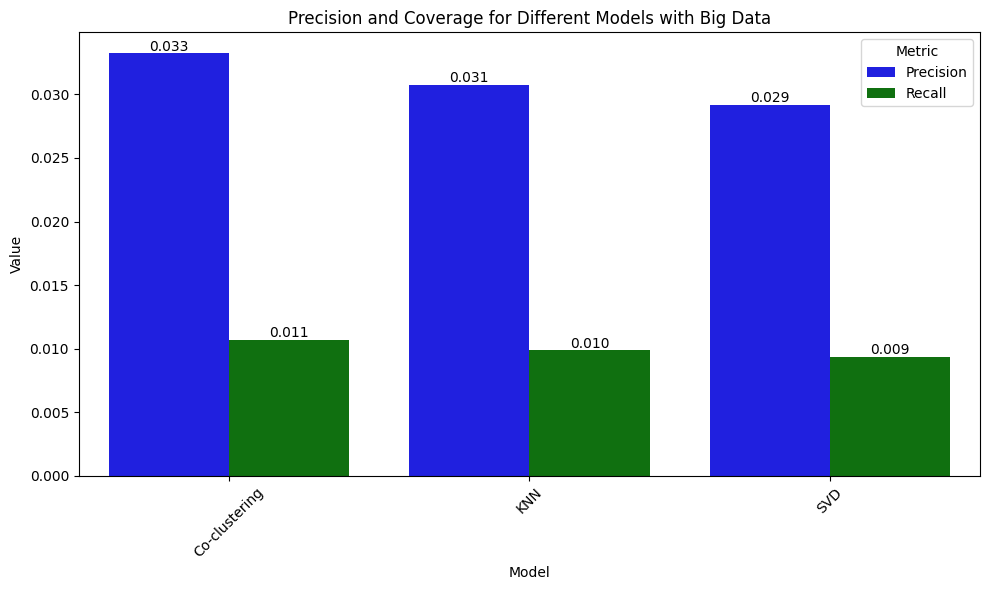

In [82]:
show_recommender_metrics(recommender_big_metrics, 'Precision and Coverage for Different Models with Big Data')

In [73]:
# dataframe to store metrics
big_models = [("Co-clustering", coclustering_big_model), 
             ("KNN", knn_big_model), 
             ("SVD", svd_big_model)]

performance_big_metrics = pd.DataFrame({"Model":[], "RMSE":[], "MAE": []})


for name, model in big_models:
    
    # evaluating the model
    evaluation = calcualte_metrics(data_test_big_convert, model)

    # adding metrics to dataframe
    performance_big_metrics = pd.concat([performance_big_metrics, pd.DataFrame({"Model": [name],
                                             "RMSE": [evaluation["RMSE"]], 
                                             "MAE": [evaluation["MAE"]]})], ignore_index=True)
    
performance_big_metrics

,Model,RMSE,MAE
0,Co-clustering,3.531842,2.442997
1,KNN,3.492440,2.427152
2,SVD,3.432222,2.429272


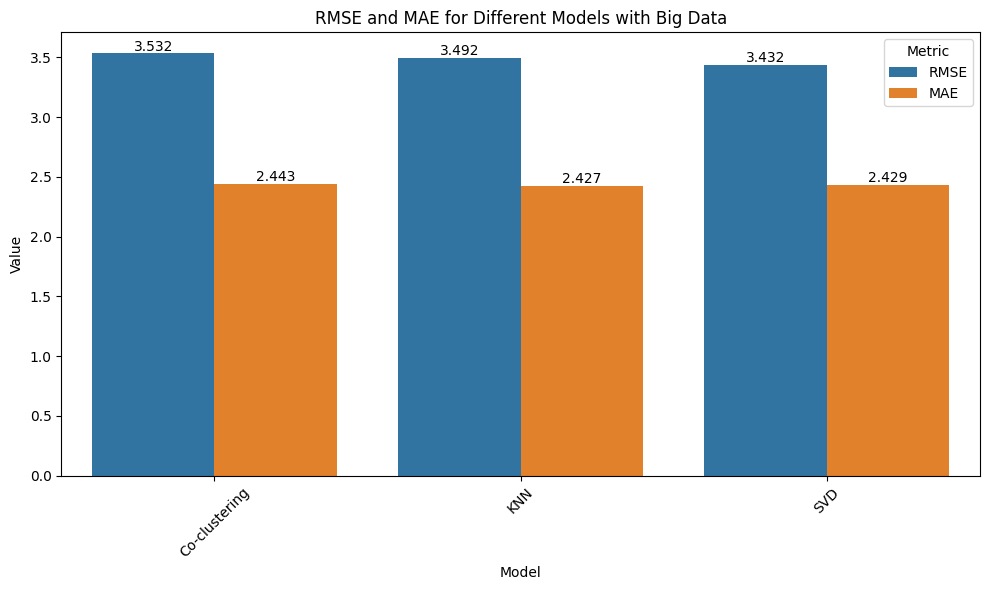

In [74]:
show_performance_metrics(performance_big_metrics, 'RMSE and MAE for Different Models with Big Data')

## Generate Recommendations

In [75]:
def choose_n_customers(dataset, n):
    customers = []
    for _ in range(n):
        u_id = random.choice(list(dataset.CustomerID))
        customers.append(u_id)
    return customers   

In [83]:
# 5 random users for test set
customers = choose_n_customers(data_test, 5)

# generating recommendation for every user, basket pairs
for u in customers: 
    print(u)
    print("{", end="")
    [print(i, end=",") for i,_ in recommend_items(coclustering_model,user_id=u, item_ids = train_unique_item)]
    print("\b ", end="")
    print("\b}")
    print()

16598
{WHITE HANGING HEART T-LIGHT HOLDER,SET OF 3 CAKE TINS PANTRY DESIGN,REGENCY CAKESTAND 3 TIER,HEART OF WICKER LARGE,REX CASH+CARRY JUMBO SHOPPER,RETROSPOT HEART HOT WATER BOTTLE,RED HANGING HEART T-LIGHT HOLDER,HOME BUILDING BLOCK WORD,HEART OF WICKER SMALL}

12748
{LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,LUNCH BAG SUKI  DESIGN,LUNCH BAG  BLACK SKULL.,JUMBO SHOPPER VINTAGE RED PAISLEY,JUMBO BAG PINK POLKADOT,LUNCH BAG CARS BLUE,LUNCH BAG WOODLAND}

16033
{WHITE HANGING HEART T-LIGHT HOLDER,JAM MAKING SET WITH JARS,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,WOODEN FRAME ANTIQUE WHITE,ASSORTED COLOUR BIRD ORNAMENT,WOODEN PICTURE FRAME WHITE FINISH}

15910
{LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,LUNCH BAG SUKI  DESIGN,LUNCH BAG  BLACK SKULL.,JUMBO SHOPPER VINTAGE RED PAISLEY,JUMBO BAG PINK POLKADOT,LUNCH BAG CARS BLUE,JUMBO  BAG BAROQUE BLACK WHITE}



In [84]:
# 5 random users for big test set
customers = choose_n_customers(data_test_big, 5)

# generating recommendation for user
for u in customers: 
    print(u)
    print("{", end="")
    [print(i, end=",") for i,_ in recommend_items(coclustering_big_model,user_id=u, item_ids = train_big_unique_item)]
    print("\b ", end="")
    print("\b}")
    print()

15017
{REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER,PARTY BUNTING,LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,SET OF 3 CAKE TINS PANTRY DESIGN,LUNCH BAG  BLACK SKULL.,SPOTTY BUNTING,LUNCH BAG SPACEBOY DESIGN}

15351
{WHITE HANGING HEART T-LIGHT HOLDER,LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,LUNCH BAG  BLACK SKULL.,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,LUNCH BAG PINK POLKADOT,LUNCH BAG SUKI DESIGN,NATURAL SLATE HEART CHALKBOARD}

13680
{WHITE HANGING HEART T-LIGHT HOLDER,LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,LUNCH BAG  BLACK SKULL.,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,LUNCH BAG PINK POLKADOT,LUNCH BAG SUKI DESIGN,NATURAL SLATE HEART CHALKBOARD}

16549
{WHITE HANGING HEART T-LIGHT HOLDER,LUNCH BAG RED RETROSPOT,JUMBO BAG RED RETROSPOT,LUNCH BAG  BLACK SKULL.,LUNCH BAG SPACEBOY DESIGN,LUNCH BAG CARS BLUE,LUNCH BAG PINK POLKADOT,LUNCH BAG SUKI DESIGN,LUNCH BAG APPLE DESIGN}

14282
{REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HO

Ba, Q., Li, X. and Bai, Z., 2013, May. Clustering collaborative filtering recommendation system based on SVD algorithm. In 2013 IEEE 4th International Conference on Software Engineering and Service Science (pp. 963-967). IEEE.

Wu, Y., Liu, X., Xie, M., Ester, M. and Yang, Q., 2016, February. CCCF: Improving collaborative filtering via scalable user-item co-clustering. In Proceedings of the ninth ACM international conference on web search and data mining (pp. 73-82).

Malaeb, M. (2020) Recall and precision at K for Recommender Systems, Medium. Available at: https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 (Accessed: 12 April 2024). 

Anwar, T., Uma, V., Hussain, M.I. and Pantula, M., 2022. Collaborative filtering and kNN based recommendation to overcome cold start and sparsity issues: A comparative analysis. Multimedia Tools and Applications, 81(25), pp.35693-35711.

Hug, N., 2020. Surprise: A Python library for recommender systems. Journal of Open Source Software, 5(52), p.2174.